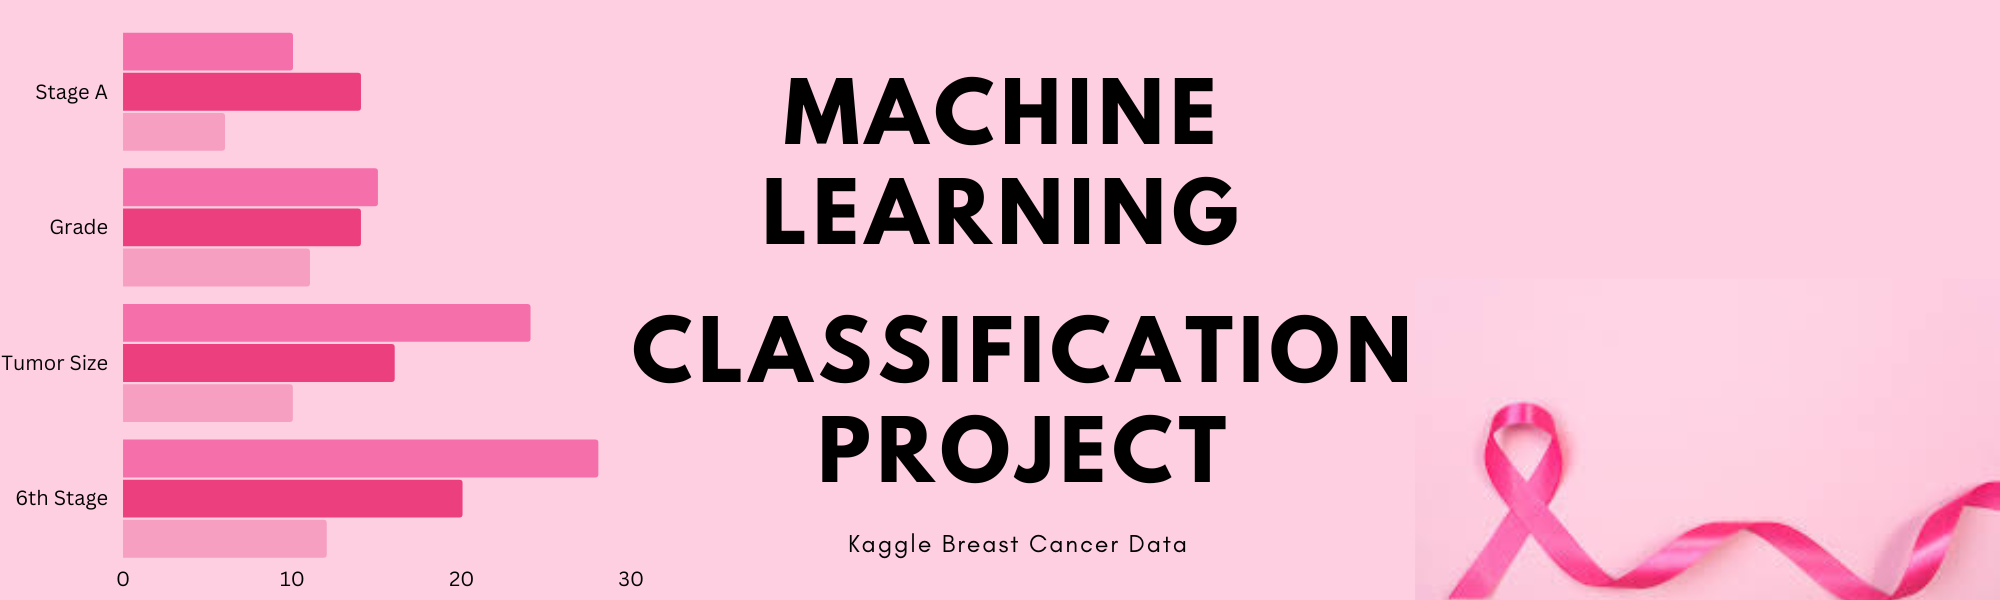

# <center><b>Predicitng the Grade</b></center>


<span style="color:pink">In this Notebook I will use a variety of models to predcit the grade of the patient. <br>
* In the original data the grade column is ordinal from 1 to 4.<br>
* the eda shows that imblanced, high volume of grade number 2 with less 1 and 3. also, a very mninmal amount of 4's.
* I will use be using a data auggmentation method called: SMOTE to syntheticly oversampled classes 1 & 3
* after consideration and to avoid overfitting, we will not try to predict grade 4 and will delete the patients with this grade from our data.
 </br></span>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from cancer_func import cancer_encode
from cancer_func import cancer_features_select

from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
from cancer_func import cancer_encode
from cancer_func import cancer_features_select
from cancer_func import cancer_encoder
from cancer_func import cancer_features_selector
from cancer_func import report, cross_validation_report
from cancer_func import cancer_encode_without_ms
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score


warnings.filterwarnings('ignore')
%matplotlib inline

# Data Observation

In [2]:
df = pd.read_csv('Breast_Cancer.csv')
df_copy = df.copy()
cancer_encoder = FunctionTransformer(cancer_encode, validate=False)
cancer_features_selector = FunctionTransformer(cancer_features_select, validate=False)
df = cancer_encode(df)
df = cancer_features_select(df)
df.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,...,Marital Status_Single,Marital Status_Widowed,6th Stage_IIA,6th Stage_IIB,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,Regional_Node_pos_%,Estrogen&Progesterone positive,Estrogen&Progesterone Negative
0,68,0.0,0.0,0.0,3.0,0.0,4,1.0,1.0,24,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.166667,1.0,0.0
1,50,1.0,1.0,2.0,2.0,0.0,35,1.0,1.0,14,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.714286,1.0,0.0
2,58,2.0,2.0,4.0,2.0,0.0,63,1.0,1.0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,1.0,0.0
3,58,0.0,0.0,0.0,3.0,0.0,18,1.0,1.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.000000,1.0,0.0
4,47,1.0,0.0,1.0,3.0,0.0,41,1.0,1.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,33.333333,1.0,0.0


Class=3.0, Count=1111, Percentage=27.609%
Class=2.0, Count=2351, Percentage=58.424%
Class=1.0, Count=543, Percentage=13.494%
Class=4.0, Count=19, Percentage=0.472%


<BarContainer object of 4 artists>

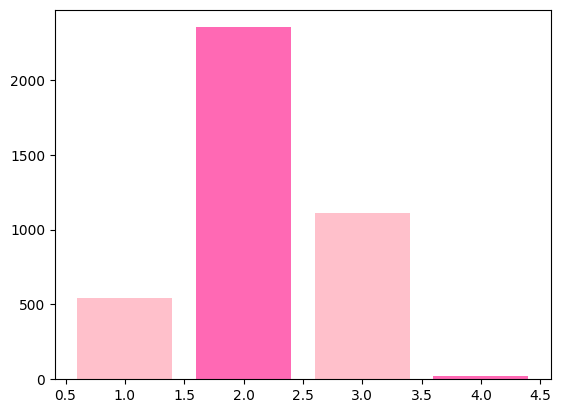

In [3]:
#plot the distribution before smote 
counter = Counter(df.Grade)
colors = ['#FFC0CB', '#FF69B4']  # Pinkish colors
for k,v in counter.items():
    per = v / len(df.Grade) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per)) 
plt.bar(counter.keys(), counter.values(), color=colors)

# Simple Models Pipeline

## Data Prepocessing

In [4]:
X = df.drop('Grade', axis=1)
y= df['Grade']

#split to train and test 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#drop grade 4 from y_train
X_train =X_train[y_train!=4]
y_train = y_train[y_train!=4]

# Encode the target variable
# le = LabelEncoder()
# y_train_encoded = le.fit_transform(y_train)
# y_test_encoded = le.transform(y_test)



# Simple Models

In [5]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),

}

## define a ascorer which prioritize 

# Calculate class weights
# Define the class weights
class_weights1 = {
    3.0: 2.0,
    2.0: 1.5,
    1.0: 1.0
}

def grade3_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred,label=3.0)

scorer = make_scorer(grade3_recall_score)

# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model.set_params(class_weight=class_weights1))
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids
param_grids = {
    'Logistic Regression': {'model__C': [0.1, 1, 10],'smote__sampling_strategy': [{1:1000,3:1000},{1:2000,3:2000},{1:2000,3:1000},{1:1000,3:2000}],"smote__k_neighbors": [5,6,7,8]},"model__class_weight": [{1:1,3:2},{1:1,3:1.5},{1:1,3:1.0}],
    'Decision Tree': {'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],'smote__sampling_strategy': [{1:1000,3:1000},{1:2000,3:2000},{1:2000,3:1000},{1:1000,3:2000}],"smote__k_neighbors": [5,6,7,8]},"model__class_weight": [{1:1,3:2},{1:1,3:1.5},{1:1,3:1.0}]}


# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

Model: Logistic Regression
Best parameters: {'model__C': 0.1, 'smote__k_neighbors': 8, 'smote__sampling_strategy': {1: 1000, 3: 1000}}
Cross-validation scores: [0.3777076  0.36499386 0.35890039 0.3978686  0.3797271 ]
Classification report:
              precision    recall  f1-score   support

         1.0       0.18      0.01      0.02       163
         2.0       0.62      0.80      0.70       706
         3.0       0.45      0.37      0.41       333
         4.0       0.00      0.00      0.00         6

    accuracy                           0.57      1208
   macro avg       0.31      0.30      0.28      1208
weighted avg       0.51      0.57      0.52      1208

-----------------------------

Model: Decision Tree
Best parameters: {'model__max_depth': 4, 'smote__k_neighbors': 5, 'smote__sampling_strategy': {1: 1000, 3: 1000}}
Cross-validation scores: [0.39683202 0.37688242 0.31761469 0.35202186 0.44616001]
Classification report:
              precision    recall  f1-score   support


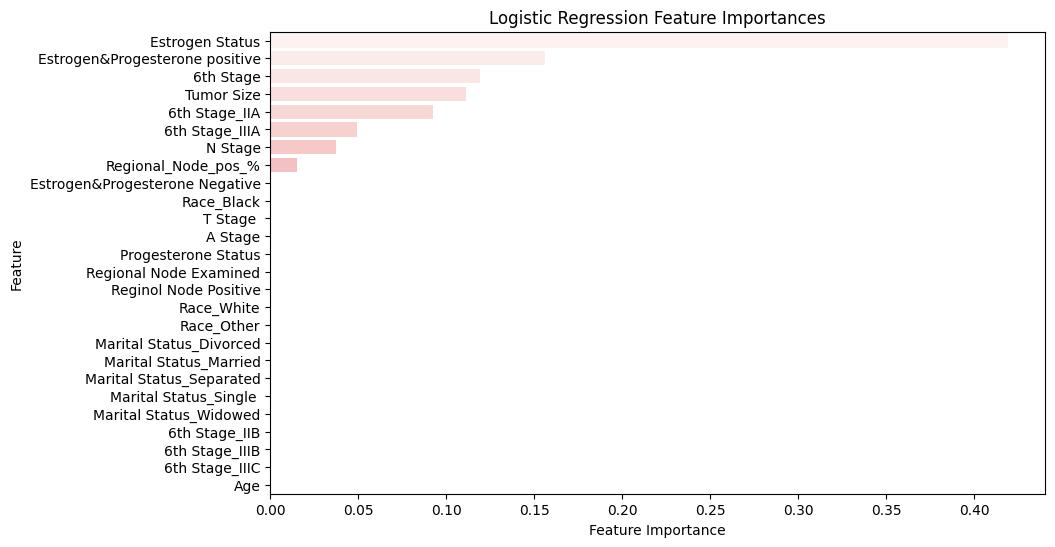

In [6]:
# Extract feature importances from the best estimator
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Set the color palette to pinkish
colors = sns.color_palette("RdPu", len(feature_names))

# Plot feature importances with pinkish colors
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Logistic Regression Feature Importances")
plt.show()

# Ensmble Methods Training

In [10]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(),
}


# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids for each model
param_grids = {
    'Random Forest': {'model__max_depth': [ 6, 7, 8, 9],'model__min_samples_leaf': [ 4, 5, 6],
                      "smote__k_neighbors": [5,6,7,8], 'smote__sampling_strategy': [{1:1000,3:1000},{1:2000,3:2000},{1:2000,3:1000},{1:1000,3:2000}], 
                      "model__class_weight": [{1:1,3:2},{1:1,3:1.5},{1:1,3:1.0}]}
}

# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

Model: Random Forest
Best parameters: {'model__class_weight': {1: 1, 3: 1.5}, 'model__max_depth': 6, 'model__min_samples_leaf': 5, 'smote__k_neighbors': 8, 'smote__sampling_strategy': {1: 1000, 3: 1000}}
Cross-validation scores: [0.45516439 0.42005811 0.38541648 0.42463306 0.44747134]
Classification report:
              precision    recall  f1-score   support

         1.0       0.33      0.09      0.14       163
         2.0       0.62      0.82      0.70       706
         3.0       0.48      0.34      0.40       333
         4.0       0.00      0.00      0.00         6

    accuracy                           0.58      1208
   macro avg       0.36      0.31      0.31      1208
weighted avg       0.54      0.58      0.54      1208

-----------------------------



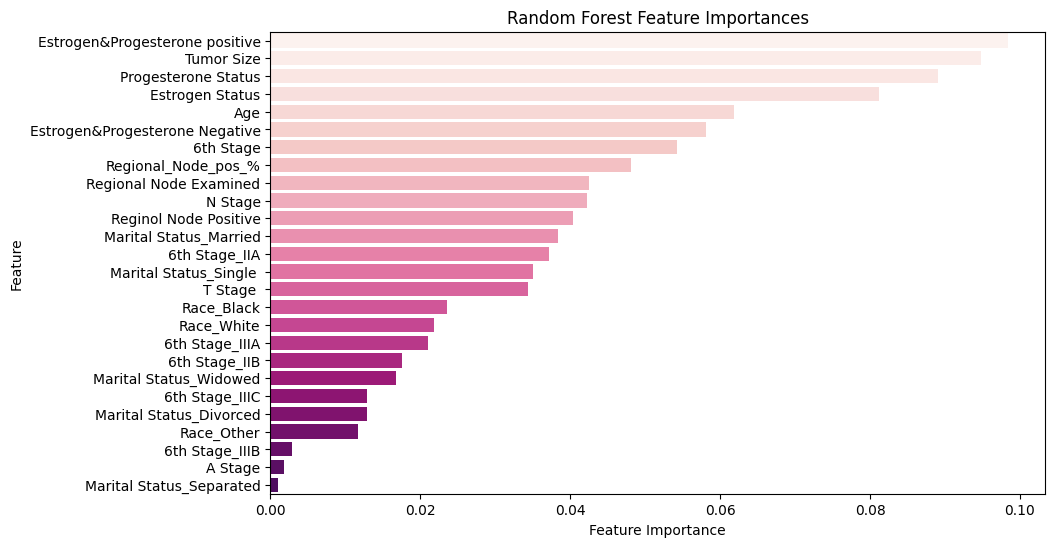

In [11]:
# Extract feature importances from the best estimator
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Set the color palette to pinkish
colors = sns.color_palette("RdPu", len(feature_names))

# Plot feature importances with pinkish colors
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

In [4]:

df = pd.read_csv('Breast_Cancer.csv')
cancer_encoder = FunctionTransformer(cancer_encode, validate=False)
cancer_features_selector = FunctionTransformer(cancer_features_select, validate=False)
df = cancer_encode(df)
df = cancer_features_select(df)

X = df.drop('Grade', axis=1)
y= df['Grade']

#split to train and test 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#drop grade 4 from y_train
X_train =X_train[y_train!=4]
y_train = y_train[y_train!=4]

y_train = y_train.astype(int)
y_train = y_train - 1

from xgboost import XGBClassifier
# Define the models
models = {
     'xgb' : XGBClassifier(),
}


# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids for each model
param_grids = {
    'model__n_estimators': [400,500,600,700], "model__gamma": [2, 3],
    "model__learning_rate": [0.05, 0.01], "smote__k_neighbors": [6,7,8],
    "model__max_depth": [3,4,6,7,8], "smote__sampling_strategy": [{1:1000,2:1000},{1:2000,2:2000},{1:2000,2:1000},{1:1000,2:2000}]
    }

# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

[18:00:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[18:00:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[18:01:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[18:01:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[18:01:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[18:01:09] WARNING: /Users/runner/work/xgboost/xgboost/

KeyboardInterrupt: 

In [ ]:
# Extract feature importances from the best estimator
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Set the color palette to pinkish
colors = sns.color_palette("RdPu", len(feature_names))

# Plot feature importances with pinkish colors
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Xgboost Feature Importances")
plt.show()

In [20]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.4 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel to use updated packages.


In [27]:
%pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [28]:
 %pip install lightgbm

  Using cached lightgbm-3.3.5.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [101 lines of output]
      INFO:root:running bdist_wheel
      /private/var/folders/7c/383s10rd2kd0r26h3dw73rgm0000gn/T/pip-install-yozeswjt/lightgbm_e98ebdb7756f49f493f6f43ea1eeb82d/setup.py:220: SetuptoolsDeprecationWarning: setup.py install is deprecated.
      !!
      
              ********************************************************************************
              Please avoid running ``setup.py`` directly.
              Instead, use pypa/build, pypa/installer, pypa/build or
              other standards-based tools.
      
              See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
              ********************************************************************************
      
      !!
        install.initialize_options(

In [30]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

df = pd.read_csv('Breast_Cancer.csv')
cancer_encoder = FunctionTransformer(cancer_encode, validate=False)
cancer_features_selector = FunctionTransformer(cancer_features_select, validate=False)
df = cancer_encode(df)
df = cancer_features_select(df)

X = df.drop('Grade', axis=1)
y= df['Grade']

#split to train and test 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#drop grade 4 from y_train
X_train =X_train[y_train!=4]
y_train = y_train[y_train!=4]

y_train = y_train.astype(int)
y_train = y_train - 1

# Define the models
models = {
     'lgbm' : LGBMClassifier(),
}


# Build pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('smote', SMOTE()),
        ('scaler', StandardScaler(with_mean=False, with_std=True)),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Define the parameter grids for each model
param_grids = {
    'model__n_estimators': [400,500,600,700],
    "model__learning_rate": [0.05, 0.01], "smote__k_neighbors": [6,7,8],
    "model__max_depth": [3,4,6,7,8],
     'model__class_weight': [
        {0: 2, 1: 1, 2: 4 },  # Example weights for each class
        {0: 1, 1: 2, 2: 4 },
        {0: 2, 1: 1, 2: 4}
    ]
    }

# Perform grid search and cross-validation for each model
for model_name, pipeline in pipelines.items():
    param_grid = param_grids
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model using cross-validation
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')

    # Generate classification report
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, sample_weight=None)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Best parameters: {best_params}")
    print(f"Cross-validation scores: {scores}")
    print(f"Classification report:\n{report}")
    print("-----------------------------\n")

ModuleNotFoundError: No module named 'lightgbm'